In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
TABLES_DIRECTORY = "../../Data/all_giant_tables"

# Set up the seaborn style
sns.set_style("whitegrid")

In [3]:
def get_patient_hup_ids(directory):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out files based on the given pattern and extract patient_hup_id as integers
    patient_hup_ids = [
        int(f.split("_")[1].split(".")[0]) for f in files if f.startswith("HUP_")
    ]

    return patient_hup_ids


directory = "../../Data/giant_new_tables"
completed_hup_ids = get_patient_hup_ids(TABLES_DIRECTORY)
completed_hup_ids.sort()
print(completed_hup_ids)
len(completed_hup_ids)

[137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 202, 204, 205, 206, 207, 210, 217, 219, 221, 223, 225]


71

In [4]:
def get_relevant_data(df, hours_before=12):
    # Find the first seizure time
    first_seizure_time = df[df["had_seizure"] >= 1]["emu_minute"].min()

    # Find the last seizure time
    last_seizure_time = df[df["had_seizure"] >= 1]["emu_minute"].max()

    # Calculate the start time for the 12-hour period before the first seizure
    start_time = (
        first_seizure_time - 2 * hours_before * 30
    )  # Since each row represents 2 minutes

    # Select the data for the period before the first seizure
    pre_seizure_data = df[
        (df["emu_minute"] >= start_time) & (df["emu_minute"] < first_seizure_time)
    ]

    # Select the data after the last seizure
    post_seizure_data = df[df["emu_minute"] > last_seizure_time]

    # Return the combined data
    return pd.concat([pre_seizure_data, post_seizure_data])


# Prepare dataframes for all patients
dfs = []
for patient_hup_id in completed_hup_ids:
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband,med_sum_no_lorazepam_raw, and had_seizure columns
    patient_features_df = patient_features_df[
        [
            "emu_minute",
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            "had_seizure",
            "time_since_last_seizure",
            "ad_ratio",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id

    # dfs.append(get_relevant_data(patient_features_df))
    dfs.append(patient_features_df)


# Combine them into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)
# drop rows with any missing values
all_data = all_data.dropna()
# Reset the index
all_data = all_data.reset_index(drop=True)

In [5]:
# Prepare the model
model = smf.mixedlm(
    "med_sum_no_lorazepam_raw ~ synchrony_broadband + time_since_last_seizure + emu_minute + ad_ratio + had_seizure",
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

# print the r^2 value
# print("r^2 value:", result.rsquared)

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: med_sum_no_lorazepam_raw
No. Observations: 248901  Method:             REML                    
No. Groups:       71      Scale:              0.0298                  
Min. group size:  115     Log-Likelihood:     83613.1979              
Max. group size:  9111    Converged:          Yes                     
Mean group size:  3505.6                                              
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.333    0.026  12.768 0.000  0.282  0.385
synchrony_broadband        -0.085    0.005 -15.643 0.000 -0.096 -0.074
time_since_last_seizure    -0.000    0.000  -0.339 0.734 -0.000  0.000
emu_minute                 -0.000    0.000 -11.167 0.000 -0.000 -0.000
ad_ratio               

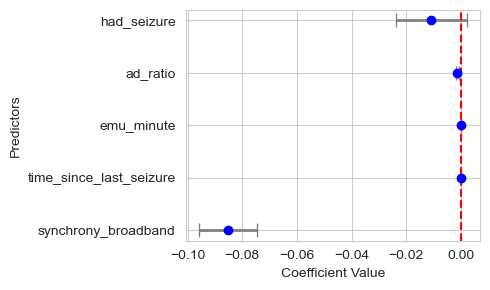

In [6]:
# Drop Group Var and Intercept from the results
coefficients = result.params.drop(["Group Var", "Intercept"]).values
predictors = result.params.drop(["Group Var", "Intercept"]).index
std_errors = result.bse.drop(["Group Var", "Intercept"]).values

# For a 95% confidence interval, z value is approximately 1.96
z_value = 1.96
conf_intervals = [
    (coef - z_value * se, coef + z_value * se)
    for coef, se in zip(coefficients, std_errors)
]

# Calculate lower and upper errors for each coefficient
lower_errors = [
    coef - ci_low for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]
upper_errors = [
    ci_high - coef for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]


# Create the coefficient plot
plt.figure(figsize=(5, 3))
for idx, (coef, predictor) in enumerate(zip(coefficients, predictors)):
    plt.errorbar(
        coef,
        idx,
        xerr=[[lower_errors[idx]], [upper_errors[idx]]],
        fmt="o",
        color="blue",
        ecolor="gray",
        elinewidth=2,
        capsize=5,
    )

# Formatting
plt.yticks(range(len(predictors)), predictors)
plt.axvline(0, color="red", linestyle="--")  # Add a vertical line for 0
plt.xlabel("Coefficient Value")
plt.ylabel("Predictors")
# plt.title("Mixed Model Coefficients with 95% Confidence Intervals")
plt.tight_layout()
plt.show()

## Dominance Analysis

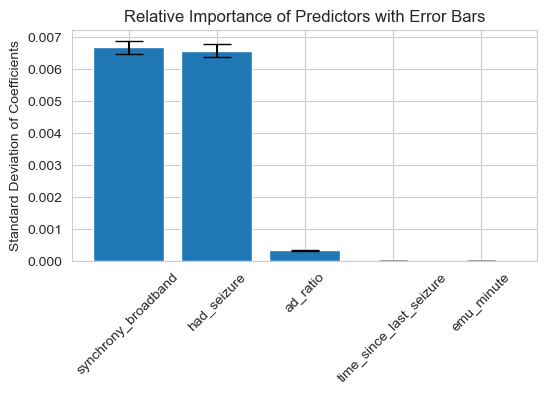

In [7]:
# Number of bootstraps
n_boots = 1000

# List of predictors
predictors = [
    "synchrony_broadband",
    "time_since_last_seizure",
    "emu_minute",
    "ad_ratio",
    "had_seizure",
]
coefficients = {pred: [] for pred in predictors}

for _ in range(n_boots):
    # Sample data with replacement
    boot_data = all_data.sample(frac=1, replace=True)

    # Fit model on bootstrap sample
    model = smf.mixedlm(
        "med_sum_no_lorazepam_raw ~ synchrony_broadband + time_since_last_seizure + emu_minute + ad_ratio + had_seizure",
        boot_data,
        groups=boot_data["patient_hup_id"],
    )
    result = model.fit()

    # Store coefficients
    for pred in predictors:
        coefficients[pred].append(result.params[pred])

# Calculate variability (standard deviation) of coefficients for each predictor
relative_importance = {pred: np.std(coefficients[pred]) for pred in predictors}

# Compute standard error for each predictor
standard_errors = {
    pred: std / np.sqrt(n_boots) for pred, std in relative_importance.items()
}

# Sort the predictors based on relative importance
sorted_predictors = sorted(
    relative_importance, key=relative_importance.get, reverse=True
)

# Visualization
plt.figure(figsize=(6, 3))
plt.bar(
    sorted_predictors,
    [relative_importance[pred] for pred in sorted_predictors],
    yerr=[standard_errors[pred] for pred in sorted_predictors],
    capsize=10,
)
plt.ylabel("Standard Deviation of Coefficients")
plt.title("Relative Importance of Predictors with Error Bars")
plt.xticks(rotation=45)  # Rotate predictor names for better readability
plt.show()

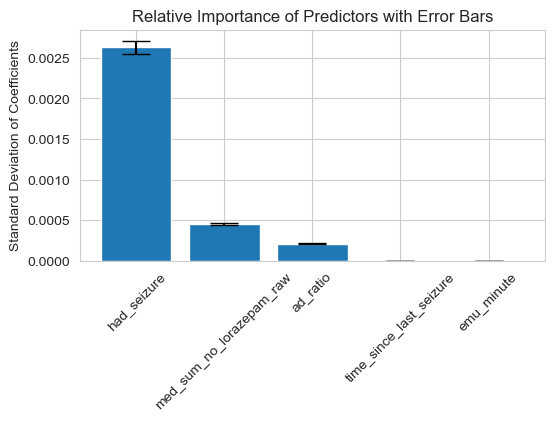

In [ ]:
# Number of bootstraps
n_boots = 1000

# List of predictors
predictors = [
    "med_sum_no_lorazepam_raw",
    "time_since_last_seizure",
    "emu_minute",
    "ad_ratio",
    "had_seizure",
]
coefficients = {pred: [] for pred in predictors}

for _ in range(n_boots):
    # Sample data with replacement
    boot_data = all_data.sample(frac=1, replace=True)

    # Fit model on bootstrap sample
    model = smf.mixedlm(
        "synchrony_broadband ~ med_sum_no_lorazepam_raw + time_since_last_seizure + emu_minute + ad_ratio + had_seizure",
        boot_data,
        groups=boot_data["patient_hup_id"],
    )
    result = model.fit()

    # Store coefficients
    for pred in predictors:
        coefficients[pred].append(result.params[pred])

# Calculate variability (standard deviation) of coefficients for each predictor
relative_importance = {pred: np.std(coefficients[pred]) for pred in predictors}

# Compute standard error for each predictor
standard_errors = {
    pred: std / np.sqrt(n_boots) for pred, std in relative_importance.items()
}

# Sort the predictors based on relative importance
sorted_predictors = sorted(
    relative_importance, key=relative_importance.get, reverse=True
)

# Visualization
plt.figure(figsize=(6, 3))
plt.bar(
    sorted_predictors,
    [relative_importance[pred] for pred in sorted_predictors],
    yerr=[standard_errors[pred] for pred in sorted_predictors],
    capsize=10,
)
plt.ylabel("Standard Deviation of Coefficients")
plt.title("Relative Importance of Predictors with Error Bars")
plt.xticks(rotation=45)  # Rotate predictor names for better readability
plt.show()

### Include seizure binary variable and time since last seizure. time of day, hour of emu stay

In [ ]:
g = sns.FacetGrid(
    all_data, col="patient_hup_id", col_wrap=3, height=4, sharex=True, sharey=True
)
g = g.map(
    sns.regplot,
    "med_sum_no_lorazepam_raw",
    "synchrony_broadband",
    scatter_kws={"s": 10, "alpha": 0.5},
    line_kws={"color": "red"},
)
g.set_titles("Patient {col_name}")
g.set_axis_labels("Medication Level", "EEG Synchrony")
plt.tight_layout()
plt.show()